In [3]:
def is_prime(n):
    if n <= 1:
        return False
    if n <= 3:
        return True
    if n % 2 == 0 or n % 3 == 0:
        return False
    i = 5
    while i * i <= n:
        if n % i == 0 or n % (i + 2) == 0:
            return False
        i += 6
    return True

In [35]:
def fill_primes(m):
    rows, cols = m.shape
    mid = round(rows ** 0.5)
    side = 0
    i = 2
    x = mid
    y = mid
    while i < rows * cols:
        side += 1
        for j in range (side):
            x += 1
            if is_prime(i):
                m[x,y] = 1
            i += 1
        for j in range (side):
            y += 1
            if is_prime(i):
                m[x,y] = 1
            i += 1
        side += 1
        for j in range (side):
            x -= 1
            if is_prime(i):
                m[x,y] = 1
            i += 1
        for j in range (side):
            y -= 1
            if is_prime(i):
                m[x,y] = 1
            i += 1
    

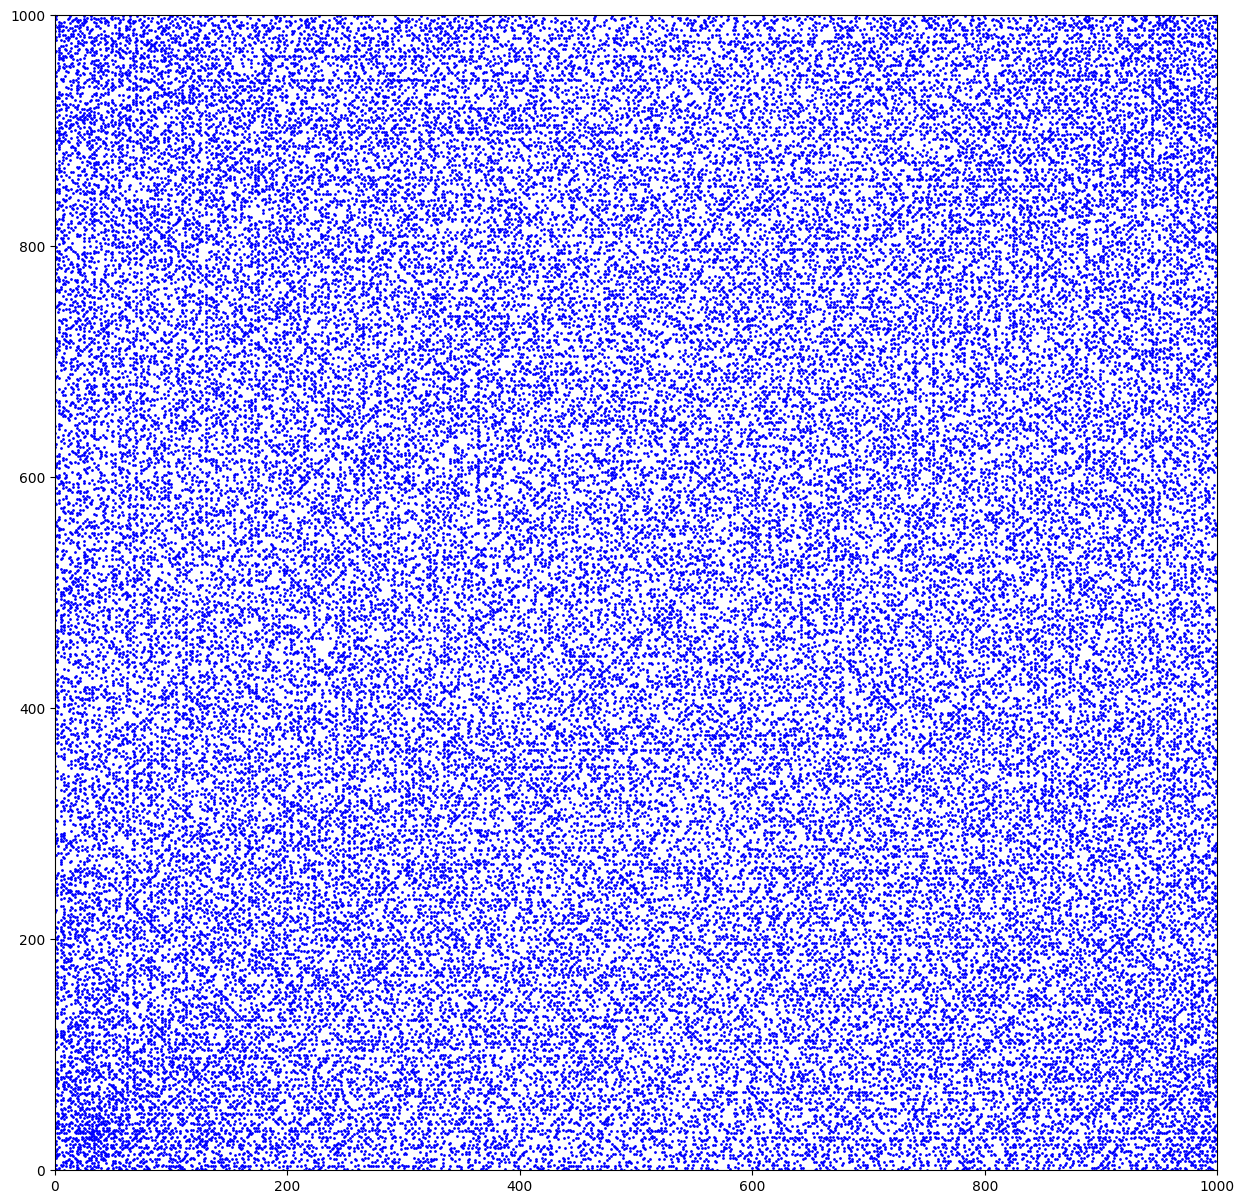

In [36]:
import numpy as np
import matplotlib.pyplot as plt

size = 1000
matrix = np.zeros((size,size))
fill_primes(matrix)
ys, xs = np.where(matrix == 1)

plt.figure(figsize=(15,15))
plt.scatter(xs, ys, c='blue', s=1)
plt.xlim(0,size)
plt.ylim(0,size)
plt.grid(False)
plt.show()